<a href="https://colab.research.google.com/github/leonardosaeta/CS2020-Group15/blob/main/Deepfake_Detector_Genesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn, optim

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time, os

# Download and unzip data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/My\ Drive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_vs_fake/real-vs-fake/valid/real/34832.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34836.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34839.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34847.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34848.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34852.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34861.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34864.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34868.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34877.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34883.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34887.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34891.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34894.jpg  
  inflating: real_vs_fake/real-vs-fake/valid/real/34904.jpg  
  inflating: real_v

# Hyperparameters and CUDA test

In [ ]:
# Hyperparameters
args = {
    'epoch_num': 10,     # number of epochs.
    'lr': 1e-4,           # Learning_Rate.
    'weight_decay': 1e-3, # Regularization.
    'batch_size': 25,     # batch size.
}

# Checking GPU
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


  # DataLoader and Transform

In [ ]:
train_dataset_path = '/content/real_vs_fake/real-vs-fake/train'
test_dataset_path = '/content/real_vs_fake/real-vs-fake/test'
validation_dataset_path = '/content/real_vs_fake/real-vs-fake/valid'

In [ ]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129,0.2075, 0.2038]

train_transform = transforms.Compose([
    transforms.Resize((224,224)), #Option to resize the images from 256 to 224 pixels
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), #Option to resize the images from 256 to 224 pixels
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])



In [ ]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform = train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform = test_transform)
validation_dataset = torchvision.datasets.ImageFolder(root = validation_dataset_path, transform = test_transform)

In [ ]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  tensor([0, 1, 0, 1, 1, 1, 0, 1, 1, 0])


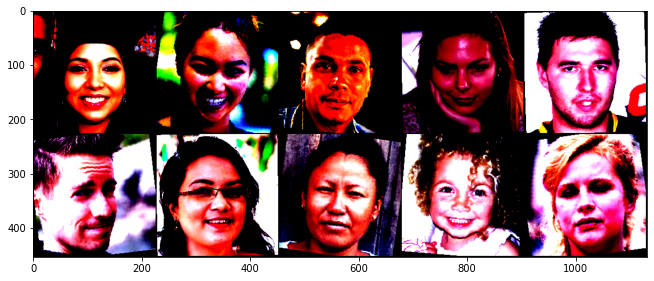

In [ ]:
show_transformed_images(train_dataset)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, args['batch_size'], shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, args['batch_size'], shuffle=True)

# VGG16 

In [ ]:
# # Defining de network
# net = nn.Sequential(
#          ## ConvBlock 1
#          nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),      # Entry: (b, 3, 224, 224) out: (b, 64, 224, 224)
#          nn.ReLU(),
#          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # Entry: (b, 64, 224, 224) out: (b, 64, 112, 112)
        
#          ## ConvBlock 2
#          nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),    # Entry: (b, 64, 112, 112) out: (b, 128, 112, 112)
#          nn.ReLU(),
#          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # Entry: (b, 128, 112, 112) out: (b, 128, 56, 56)
        
#          ## ConvBlock 3
#          nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),   # Entry: (b, 128, 56, 56) out: (b, 256, 56, 56)
#          nn.ReLU(),
#          nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),   # Entry: (b, 256, 56, 56) out: (b, 256, 56, 56)
#          nn.ReLU(),
#          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # Entry: (b, 256, 56, 56) out: (b, 256, 28, 28)
        
#          ## ConvBlock 4
#          nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),   # Entry: (b, 256, 28, 28) out: (b, 512, 28, 28)
#          nn.ReLU(),
#          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # Entry: (b, 512, 28, 28) out: (b, 512, 28, 28)
#          nn.ReLU(),
#          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # Entry: (b, 512, 28, 28) out: (b, 512, 14, 14)
        
#          ## ConvBlock 4
#          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # Entry: (b, 512, 14, 14) out: (b, 512, 14, 14)
#          nn.ReLU(),
#          nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),   # Entry: (b, 512, 14, 14) out: (b, 512, 14, 14)
#          nn.ReLU(),
#          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),          # Entry: (b, 512, 14, 14) out: (b, 512, 7, 7)
#          nn.Flatten(),                                              # Entry: (b, 512, 7, 7) out: (b, 512*7*7) = (b, 25088)
 
#          ## DenseBlock
#          nn.Linear(25088, 5000),                                    # Entry: (b, 25088) out: (b, 4096)
#          nn.ReLU(),
#          nn.Dropout(p=0.5),                                     # Entry: (b, 4096) out: (b, 4096)
#          nn.ReLU(),
#          nn.Linear(5000, 2),                                       # Entry: (b, 4096) out: (b, 25088)
#          nn.LogSoftmax(dim=1)
#          )

#  # Uploading hardware to GPU (if available)
# net = net.to(args['device'])

# LeNet5 #

In [ ]:
net = torchvision.models.alexnet(pretrained=False)

In [ ]:
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([('fcl', nn.Linear(9216, 25)),
                                         ('relu', nn.ReLU()),
                                         ('drop', nn.Dropout(p=0.5)),
                                         ('fc2', nn.Linear(25, 2)), # outuput equals 2
                                         ('output', nn.LogSoftmax(dim=1))]))

net.classifier = classifier

In [ ]:
net = net.to(args['device'])

In [ ]:
net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fcl): Linear(in_features=9216, out_features=25, bias=True)
    (relu): ReLU()
    (drop): Dropout(p

# Optimizer #

In [ ]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Train and Validation# 

In [ ]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    
    dado, rotulo = batch
  
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()


In [ ]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast the data to GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

      if epoch % 5 == 0:
        torch.save(net.state_dict(), 'checkpoint.pth')

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()

In [ ]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 0.3468 +/- 0.1203, Acc: 85.85, Time: 395.40
********** Validate **********
Epoch 0, Loss: 0.3011 +/- 0.0907, Acc: 87.35, Time: 110.76

#################### Train ####################
Epoch 1, Loss: 0.3092 +/- 0.1188, Acc: 87.56, Time: 448.91
********** Validate **********
Epoch 1, Loss: 0.3027 +/- 0.1014, Acc: 87.53, Time: 86.72

#################### Train ####################
Epoch 2, Loss: 0.2800 +/- 0.1155, Acc: 88.85, Time: 383.94
********** Validate **********
Epoch 2, Loss: 0.2511 +/- 0.1067, Acc: 89.30, Time: 66.32

#################### Train ####################
Epoch 3, Loss: 0.2572 +/- 0.1159, Acc: 89.93, Time: 375.46
********** Validate **********
Epoch 3, Loss: 0.2336 +/- 0.0952, Acc: 90.18, Time: 65.90

#################### Train ####################
Epoch 4, Loss: 0.2398 +/- 0.1139, Acc: 90.73, Time: 380.74
********** Validate **********
Epoch 4, Loss: 0.3069 +/- 0.1625, Acc: 87.73, Time: 67.66

##############

In [ ]:
netL = net 

In [ ]:
netL.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-2.2298e-02, -5.2127e-02, -7.4095e-02,  ..., -2.9982e-02,
                         -1.4642e-02, -1.9448e-02],
                        [-8.4674e-03, -3.6216e-03, -4.8729e-02,  ..., -4.1178e-02,
                         -3.1474e-02, -2.2319e-02],
                        [ 9.5735e-03, -5.3628e-03, -4.4527e-02,  ..., -3.2409e-02,
                         -2.7632e-02, -7.2080e-03],
                        ...,
                        [ 3.1811e-02,  5.0921e-03, -1.0389e-02,  ..., -3.0676e-04,
                         -3.9745e-02, -1.6962e-02],
                        [ 1.1288e-02,  1.7851e-02, -7.6969e-04,  ..., -1.5226e-02,
                          1.8070e-03, -2.5196e-02],
                        [ 7.0372e-03, -9.1585e-03,  2.3428e-02,  ...,  2.8315e-02,
                          2.1930e-02,  1.5006e-02]],
              
                       [[-8.6889e-03, -4.2570e-03,  2.2830e-02,  ...,  4.5491e-02,
                          3

In [ ]:
netL.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [ ]:
netL.state_dict

<bound method Module.state_dict of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fcl): Linear(in_features=9216, out_features=25, bias=True)
    (